# Use the Analytical Model of Childress (for the good)

Scope: Learning as few parameters as possible to describe the decay dynamics of the single NV centre qubit

A. Gentile

08/2017

In [2]:
import qinfer as qi
import numpy as np
import scipy as sp
from scipy import signal
import qutip as qt
import sys, os
import importlib as imp

In [3]:
import matplotlib.pyplot as plt
import pylab 

In [4]:
# Add personalized library to PYTHONPATH
sys.path.append(os.path.join(".."))
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [5]:
dire = os.path.normpath(os.getcwd())
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks


In [6]:
import IOfuncts as mIO

In [7]:
imp.reload(mIO)

<module 'IOfuncts' from '..\\Libraries\\QML_lib\\IOfuncts.py'>

### Hahn-echo signal experimental data

Import experimental data ad libitum

In [8]:
directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02_second_tauequtaudeg")

counter = 0
Hahn_data = []
for root,dirs,files in os.walk(directory):
    for filename in files:  
        if filename.endswith(".csv"):
            newfilename = os.path.join(directory, filename)
            print(os.path.abspath(newfilename))
            #usecols only selects one normalisation 
            Hahn_data.append((np.loadtxt(os.path.abspath(newfilename), delimiter=",", usecols=(0,1), skiprows=1)).tolist())

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho02_second_tauequtaudeg\analysis_01.csv
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho02_second_tauequtaudeg\analysis_02.csv


In [9]:
Hahn_data = [item for sublist in Hahn_data for item in sublist]

In [10]:
Hahn_data = np.asarray(Hahn_data)
Hahn_data = Hahn_data[Hahn_data[:,0].argsort()]

In [11]:
Hahn_data.shape

(99, 2)

In [12]:
u, indices = np.unique(Hahn_data[:,0], return_index=True)
clean_Hahn_data = np.array([[Hahn_data[i, 0], Hahn_data[i, 1]] for i in indices])

Select a range of data to plot (makes the oscillatory behaviour more clear 
when datasets are intervalled by huge "gaps").
I have selected the first three oscillations as there are no "gaps" in between them as data collection, which makes it a bit easier to infer a possible fit

In [13]:
myrange = range(0, min(clean_Hahn_data.shape[0],96)) 
xdata = clean_Hahn_data[myrange,0]/1000 # converted to us
ydata = clean_Hahn_data[myrange,1]

In [14]:
prepydata = mIO.rescaledatatomin(ydata, newrange = [0.5,1.])

In [15]:
def func(t, offset, ratio, T2):
    return ratio * np.exp(- (2*t / T2)**3) +offset 

In [16]:
popt, pcov = sp.optimize.curve_fit(func, xdata, prepydata, bounds=(0, [1., 1., 300.]))
perr = np.sqrt(np.diag(pcov))
print(r'Estimated T2 from data-fit: ' + str(popt[2]) + ' +/- ' + str(perr[2]) + ' us')

Estimated T2 from data-fit: 144.190289291 +/- 59.9824829887 us


The huge st.dev. associated with T2 is probably due to heterodox fitting to whole dataset (instead of estimated peaks). 

E.g. in Lily's thesis $T_2 = 242 \pm 16 \mu$s 

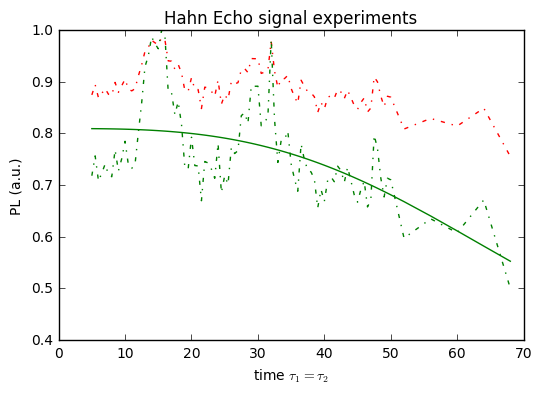

In [17]:
plt.plot(xdata, func(xdata, *popt), 'g-', label='fit-with-bounds')

plt.plot(xdata, ydata, "r-.", label='raw-data')
plt.plot(xdata, prepydata, "g-.", label='rescale-data')
plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

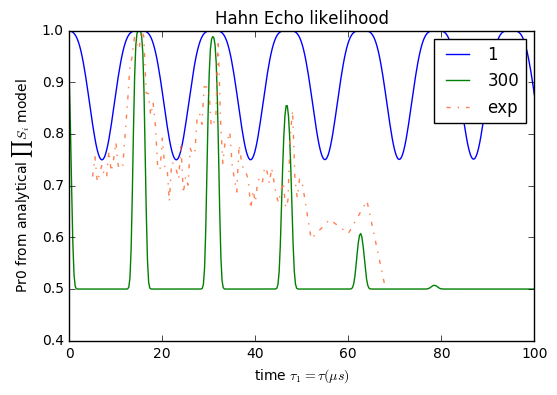

In [338]:
tvec = np.linspace(0.,100,400)
offset = 15.

#simsizes controls the width of the peaks, as well as T2
simsizes = [1, 30] #30
evolve = np.empty([len(tvec),len(simsizes)])

mean = 0.39   #controls the frequency of the revivals
delta = 0.01   #increases the appearance of secondary peaks
sigma = 29.7*10**-3   # controls the T2 decay, as well as how "clean" the revivals will be 
theoffset = 0.5  # controls the visibility of initial peaks (<0.5), but also the final collapse value, influences the width of the peaks

# sigma is fixed given simsizes, and viceversa


# mean = 0.39
# delta = 0.01
# sigma = 29.7*10**-3

for simsize in simsizes:
    
#     freqsa = np.repeat(7, simsize) 
    freqsa = np.random.normal(loc=mean+delta, scale=sigma, size=simsize)   #loc=3, scale=2*10**-3   ///for correct simulation of T2 with ~100 qubits coupled 
    freqsb = np.random.normal(loc=mean, scale=sigma, size=simsize)    #loc=3, scale=2*10**-3
    
#     freqsa = np.random.normal(loc=5, scale=10**-3, size=simsize)
#     freqsb = np.random.normal(loc=0.5, scale=10**-3, size=simsize)

    for idt in range(len(tvec)):
        
        shifted_t = tvec[idt]-offset
        S = [1 - theoffset*((np.sin(freqsa[i]*shifted_t/2))**2)*((np.sin(freqsb[i]*shifted_t/2))**2)   for i in range(len(freqsa))]
        
        ## checks what happens if the nuclei had precession independent of the electron spin
#         S = [1 - 1*((np.sin(freqsa[i]*tvec[idt]))**2)*((np.sin(freqsa[i]*tvec[idt]))**2)   for i in range(len(freqsa))]

        evolve[idt, simsizes.index(simsize)] = (np.prod(S)+1)/2

for size in simsizes:
    plt.plot(tvec, evolve[:, simsizes.index(size)], label=str(size))

plt.plot(xdata, prepydata, "-.", color='coral', label='exp')

plt.legend()

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 = \tau (\mu s)$')
plt.ylabel(r'Pr0 from analytical $\prod S_i$ model')

plt.show()

### Hahn-echo signal experimental data - 2nd run

Import experimental data ad libitum

In [18]:
directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho01_highres")

counter = 0
Hahn_data = []
for root,dirs,files in os.walk(directory):
    for filename in files:  
        if filename.endswith(".csv") and filename.startswith("ana"):
            newfilename = os.path.join(directory, filename)
            print(os.path.abspath(newfilename))
            #usecols only selects one normalisation
            if filename.endswith("s.csv"):
                Hahn_data.append((np.loadtxt(os.path.abspath(newfilename), delimiter=",", usecols=(0,1), skiprows=1)).tolist())
            else:
                temp = (np.loadtxt(os.path.abspath(newfilename), delimiter=",", usecols=(0,1), skiprows=1) )
                rescale = (mIO.rescaledatatomin(temp[:,1], newrange = [0.8, 0.84]))
                temp = [  [temp[i,0], rescale[i]] for i in range(len(temp)) ]
                Hahn_data.append(temp[10:-5])

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho01_highres\analysis.csv
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho01_highres\analysis_02.csv


In [19]:
Hahn_data = [item for sublist in Hahn_data for item in sublist]

In [20]:
Hahn_data = np.asarray(Hahn_data)
Hahn_data = Hahn_data[Hahn_data[:,0].argsort()]

In [21]:
Hahn_data.shape

(438, 2)

In [22]:
u, indices = np.unique(Hahn_data[:,0], return_index=True)
clean_Hahn_data = np.array([[Hahn_data[i, 0], Hahn_data[i, 1]] for i in indices])

Select a range of data to plot (makes the oscillatory behaviour more clear 
when datasets are intervalled by huge "gaps").
I have selected the first three oscillations as there are no "gaps" in between them as data collection, which makes it a bit easier to infer a possible fit

In [23]:
myrange = range(0, min(clean_Hahn_data.shape[0],440)) 
xdata = clean_Hahn_data[myrange,0]/1000 # converted to us
ydata = clean_Hahn_data[myrange,1]

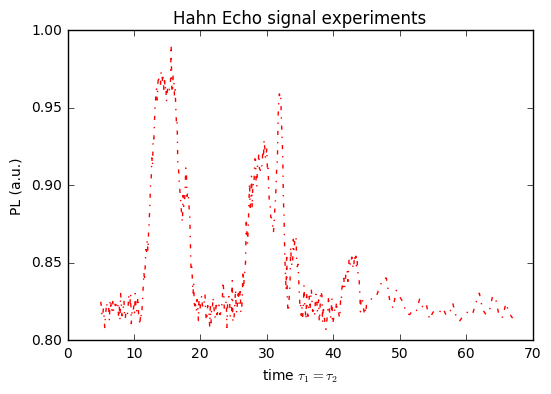

In [24]:
plt.plot(xdata, ydata, "r-.", label='raw-data')
plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

In [25]:
prepydata = mIO.rescaledatatomin(ydata, newrange = [0.5,1.])

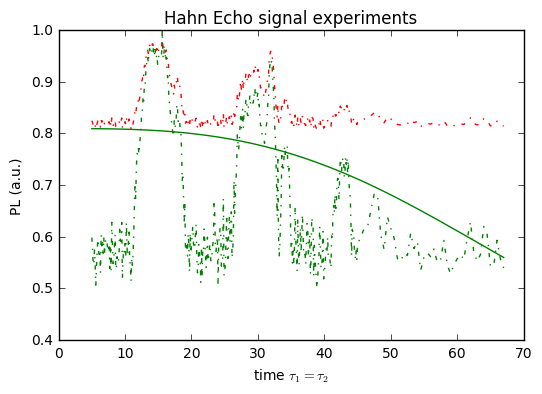

In [26]:
plt.plot(xdata, func(xdata, *popt), 'g-', label='fit-with-bounds')

plt.plot(xdata, ydata, "r-.", label='raw-data')
plt.plot(xdata, prepydata, "g-.", label='rescale-data')
plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

In [43]:
nparam = 2

tvec = np.linspace(0.,60,400)
offset = 0.

#simsizes controls the width of the peaks, as well as T2
Nqubit = 20
nrep = 10

evolve = np.empty([nrep, len(tvec), nparam])

# values for non-shifted curve
mean =  0.385   #controls the frequency of the revivals
delta =  5.7*10**-2  #increases the appearance of secondary peaks
sigma =   17*10**-3 # controls the T2 decay, as well as how "clean" the revivals will be 
magoffset = 0.45 # controls the visibility of initial peaks (<0.5), but also the final collapse value, influences the width of the peaks
sigmaO = 0.015 # controls the T2 decay, as well as how "clean" the revivals will be 


# values for shifted curve
# mean = 0.36   #controls the frequency of the revivals
# delta = 9*10**-2  #increases the appearance of secondary peaks
# sigma = 30*10**-3 # controls the T2 decay, as well as how "clean" the revivals will be 
# theoffset = 0.5 # controls the visibility of initial peaks (<0.5), but also the final collapse value, influences the width of the peaks
# sigmaO = 0.01 # controls the T2 decay, as well as how "clean" the revivals will be 


# mean = 0.39
# delta = 0.01
# sigma = 29.7*10**-3

# sigma is fixed given simsizes, and viceversa

# params = np.around(np.linspace(5, 40, nparam), 0).tolist()
# params = np.linspace(0.3, 0.4, nparam).tolist()
# params = np.linspace(1*10**-2, 10*10**-2, nparam).tolist()
# params = np.linspace(10*10**-3, 20*10**-3, nparam).tolist()
# params = np.linspace(0.3, 0.7, nparam).tolist()
# params = np.linspace(0.01, 0.2, nparam).tolist()
params = np.around(np.linspace(1, Nqubit, nparam), 0).tolist()


for repeats in range(nrep):

    for param in params:
        
        Nqubit = int(param)

#         freqsa = np.repeat(mean+delta, simsize) 
        freqsa = np.random.normal(loc=mean+delta, scale=sigma, size=Nqubit)   #loc=3, scale=2*10**-3   ///for correct simulation of T2 with ~100 qubits coupled 
        freqsb = np.random.normal(loc=mean, scale=sigma, size=Nqubit)    #loc=3, scale=2*10**-3
#         magoffsets = np.repeat(magoffset, simsize) 
        magoffsets = np.random.normal(loc=magoffset, scale=sigmaO, size=Nqubit)

        for idt in range(len(tvec)):

            shifted_t = tvec[idt]-offset
            S = [1 - magoffsets[i]*((np.sin(freqsa[i]*shifted_t/2))**2)*((np.sin(freqsb[i]*shifted_t/2))**2)   for i in range(len(freqsa))]

            evolve[repeats, idt, params.index(param)] = (np.prod(S)+1)/2

evolve = np.mean(evolve, axis=0)

In [131]:
modeldata = evolve[:, 1]
peakind = signal.find_peaks_cwt(modeldata, np.arange(16, 30))
peakind[0] -=9
peakind[1] -=4
peakind[2] -=5
peakind[3] -=4
peakind[4] -=5
[tvec[peakind], modeldata[peakind]]

[array([  0.45112782,  14.73684211,  29.62406015,  42.70676692,  56.84210526]),
 array([ 0.99966613,  0.98907213,  0.86836428,  0.71334073,  0.60967899])]

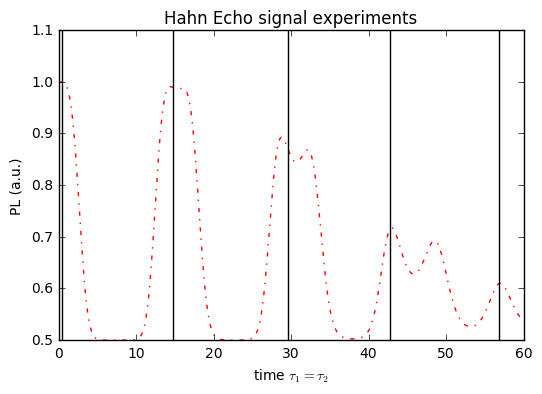

In [144]:
plt.plot(tvec, modeldata, "r-.", label='model-data')

for xc in tvec[peakind][:]:
    plt.axvline(x=xc, ls = '-', color = 'black')

plt.title('Hahn Echo signal experiments')

plt.xlabel(r'time $\tau_1 = \tau_2$')
plt.ylabel('PL (a.u.)')

plt.show()

In [145]:
def func(t, offset, ratio, T2):
    return ratio * np.exp(- (2*t / T2)**3) +offset 

In [148]:
popt2, pcov2 = sp.optimize.curve_fit(func, tvec[peakind][:], modeldata[peakind][:], bounds=(0, [1., 1., 300.]))
perr2 = np.sqrt(np.diag(pcov2))
print(r'Estimated T2 from peaks-fit: ' + str(popt2[2]) + ' +/- ' + str(perr2[2]) + ' us')

Estimated T2 from peaks-fit: 81.2406425661 +/- 1.31651795528 us


C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\HahnSignalAnalytical.pdf


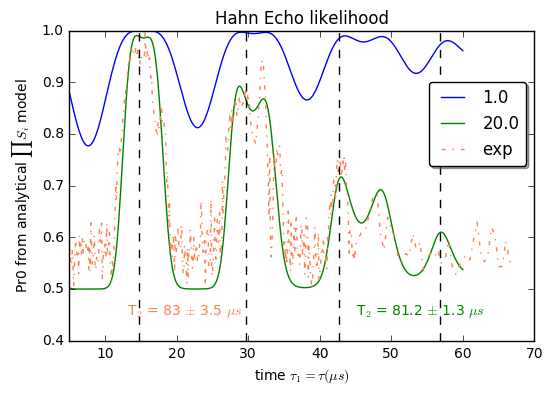

In [150]:
for param in params:
    plt.plot(tvec, evolve[:, params.index(param)], label=str(np.around(param,0))   )

plt.plot(xdata, prepydata, "-.", color='coral', label='exp')

pylab.xlim([min(xdata), 70])

T2 = str(np.around(popt2[2],1))
T2err = str(np.around(perr2[2],1))

plt.text(13, 0.45, r'T$_2$ = 83 $\pm$ 3.5 $\mu s$' , color = 'coral')
plt.text(45, 0.45, r'T$_2$ = ' + T2 + ' $\pm$ ' + T2err + ' $\mu s$' , color = 'green')

for xc in tvec[peakind][0:]:
    plt.axvline(x=xc, ls = '--', color = 'black')

plt.legend(loc='right', bbox_to_anchor=(1.0,0.7), ncol=1, #bbox_to_anchor=(1.5,  1.0), ncol=3, 
           fancybox=True, shadow=True)
  
plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 = \tau (\mu s)$')
plt.ylabel(r'Pr0 from analytical $\prod S_i$ model')

thisfig = "_trackloss___"
filefigname = dire+"\\HahnSignalAnalytical.pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
plt.savefig(filefigname)

plt.show()

## Nelder-Mead Optimise the model against experimental data

no method appears to work :((

In [151]:
def mymodel(x, u):
    
    simsize = 20
    nrep = 10
    
    mean = x[0]
    delta  = x[1]
    sigma = x[2]
    magoffset = x[3]
    sigmaO = x[4]
    
    evolve = np.empty(nrep)
    
    for repeats in range(nrep):

#         freqsa = np.repeat(mean+delta, simsize) 
        freqsa = np.random.normal(loc=mean+delta, scale=sigma, size=simsize)   #loc=3, scale=2*10**-3   ///for correct simulation of T2 with ~100 qubits coupled 
        freqsb = np.random.normal(loc=mean, scale=sigma, size=simsize)    #loc=3, scale=2*10**-3
#         theoffsets = np.repeat(theoffset, simsize) 
        magoffsets = np.random.normal(loc=magoffset, scale=sigmaO, size=simsize)

        S = [1 - magoffsets[i]*((np.sin(freqsa[i]*u/2))**2)*((np.sin(freqsb[i]*u/2))**2)   for i in range(len(freqsa))]

        evolve[repeats] = (np.prod(S)+1)/2

    evolve = np.mean(evolve)
    return evolve

In [152]:
def myfun(x, u, y):
    return (mymodel(x, u) - y)

def myfunO(x, u, y):
    return sum( (mymodel(x, u) - y)**2 )

In [159]:
x0 = np.array([0.52, 0.43, 0.126, 0.5, 0.1])
myfunO(x0, u, y)

22.029958379171521

In [154]:
from scipy.optimize import least_squares, minimize

x0 = np.array([0.42, 0.03, 0.026, 0.5, 0.1])

u = xdata
y = prepydata

#does NOT work, maybe absent Jacobian fools it? exits soon with same input values, does not detect any gradient
# res = least_squares(myfun, x0, bounds=(0,1), args=(u, y), verbose=1)

#>Nelder mead, Powell #goes for a while, does not find any better solution 
#>L-BFGS-B , SLSQP , TLC : useless (exit at evaluation 0)
res = minimize(myfunO, x0, method='SLSQP', bounds=[(0,1),(0,0.1),(0,0.1),(0,1),(0,0.2)], args=(xdata, prepydata), options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 22.0299583792
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1


In [1301]:
res.x

array([ 0.42 ,  0.03 ,  0.026,  0.5  ,  0.1  ])

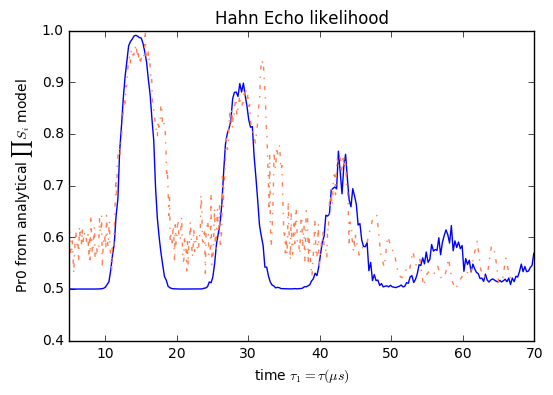

In [1303]:
startdata = [mymodel(x0, t) for t in tvec]
plt.plot(tvec, startdata, label=str(size))

plt.plot(xdata, prepydata, "-.", color='coral', label='exp')

pylab.xlim([min(xdata), 70])

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 = \tau (\mu s)$')
plt.ylabel(r'Pr0 from analytical $\prod S_i$ model')

plt.show()